# Exploratory Data Analysis

## 1. Data Cleaning and Preprocessing


In [1]:
# Imports
from bigquery import download_data_from_bigquery_to_local
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import re
from tqdm import tqdm
import numpy as np
from constants import TRACK_CLASSES, MISSPELLINGS_MADRID

from dataframe_utils import extract_and_store_patterns
from address_utils import correct_spelling
from dataframe_utils import get_unique_names, fill_na_df
import random

In [2]:
# Import data as a pandas dataframe
df = download_data_from_bigquery_to_local(
    dataset_id="idealista_listings",
    table_id="sale-madrid-production",
    credentials_path="~/.gcp/prefect-agent.json",
    local_path=None,
    format="pandas",
)
# Record the initial number of rows
n = len(df)

Starting extraction of 54986 rows...
Extraction complete.


In [3]:
# Check that the casted dtypes are correct
df.dtypes

ID_LISTING                               object
URL                                      object
TYPE_PROPERTY                            object
ADDRESS                                  object
LOCATION                                 object
FULL_ADDRESS                             object
ZIP_CODE                                 object
LATITUDE                                float64
LONGITUDE                               float64
IMPORTANCE_LOCATION                     float64
LOCATION_ID                               Int64
PRICE                                   float64
ORIGINAL_PRICE                          float64
CURRENCY                                 object
TAGS                                     object
LISTING_DESCRIPTION                      object
POSTER_TYPE                              object
POSTER_NAME                              object
BUILT_AREA                              float64
USEFUL_AREA                             float64
LOT_AREA                                

In [4]:
# Cast some columns
df["LAST_UPDATE_DATE"] = pd.to_datetime(df["LAST_UPDATE_DATE"])
df["ZIP_CODE"] = pd.to_numeric(df["ZIP_CODE"], errors="coerce")

In [5]:
# Inspect first rows to check data structure
df.head()

,ID_LISTING,URL,TYPE_PROPERTY,ADDRESS,LOCATION,FULL_ADDRESS,ZIP_CODE,LATITUDE,LONGITUDE,IMPORTANCE_LOCATION,...,YEAR_BUILT,NUM_FLOORS,FLOOR,STATUS_EPC,ENERGY_CONSUMPTION_LABEL,ENERGY_EMISSIONS_LABEL,ENERGY_CONSUMPTION,ENERGY_EMISSIONS,LAST_UPDATE_DATE,TIMESTAMP
0,102102033,https://www.idealista.com/inmueble/102102033/,Chalet pareado,"Centro Urbano, Denia",Denia,"Dénia, la Marina Alta, Alacant / Alicante, Com...",NaN,38.840839,0.106110,0.509953,...,2023,2,NaN,En trámite,None,None,NaN,NaN,2023-07-21,2023-07-21 13:41:28+00:00
1,102225381,https://www.idealista.com/inmueble/102225381/,Estudio,"calle de los Jardines, Sol, Madrid","Sol, Madrid","Calle de los Jardines, Barrio de los Austrias,...",28013.0,40.418934,-3.700804,0.820010,...,<NA>,<NA>,1.0,Disponible,a,a,NaN,NaN,2023-08-03,2023-08-04 01:25:45+00:00
2,101728088,https://www.idealista.com/inmueble/101728088/,Piso,"calle de Bordadores, Sol, Madrid","Sol, Madrid","Los Andes, 1, Calle de Bordadores, Barrio de l...",28013.0,40.416294,-3.707907,0.630010,...,<NA>,<NA>,2.0,En trámite,None,None,NaN,NaN,2023-06-13,2023-06-14 14:44:28+00:00
3,101723836,https://www.idealista.com/inmueble/101723836/,Piso,"Bordadores, Sol, Madrid","Sol, Madrid","Los Andes, 1, Calle de Bordadores, Barrio de l...",28013.0,40.416294,-3.707907,0.430010,...,<NA>,<NA>,2.0,En trámite,None,None,NaN,NaN,2023-06-13,2023-06-14 14:58:48+00:00
4,101554335,https://www.idealista.com/inmueble/101554335/,Piso,"calle de Atocha, Sol, Madrid","Sol, Madrid","Calle de Atocha, Barrio de los Austrias, Sol, ...",28012.0,40.414631,-3.704915,0.720010,...,1900,<NA>,2.0,En trámite,None,None,NaN,NaN,2023-05-26,2023-05-27 13:43:30+00:00


In [6]:
# Check for missing values
df.isna().sum()

ID_LISTING                      0
URL                             0
TYPE_PROPERTY                   0
ADDRESS                         0
LOCATION                        0
FULL_ADDRESS                  340
ZIP_CODE                     7542
LATITUDE                      340
LONGITUDE                     340
IMPORTANCE_LOCATION           340
LOCATION_ID                   340
PRICE                           0
ORIGINAL_PRICE              54986
CURRENCY                        0
TAGS                            0
LISTING_DESCRIPTION             0
POSTER_TYPE                     0
POSTER_NAME                     0
BUILT_AREA                      0
USEFUL_AREA                 32975
LOT_AREA                    54039
NUM_BEDROOMS                    0
NUM_BATHROOMS                   0
CONDITION                       1
AIR_CONDITIONING                0
HEATING                     14558
BUILTIN_WARDROBE                0
ELEVATOR                     2086
PROPERTY_ORIENTATION         3786
FLAG_PARKING  

In [7]:
# Check data types
df.describe()

,ZIP_CODE,LATITUDE,LONGITUDE,IMPORTANCE_LOCATION,LOCATION_ID,PRICE,ORIGINAL_PRICE,BUILT_AREA,USEFUL_AREA,LOT_AREA,NUM_BEDROOMS,NUM_BATHROOMS,PARKING_PRICE,YEAR_BUILT,NUM_FLOORS,FLOOR,ENERGY_CONSUMPTION,ENERGY_EMISSIONS
count,4.744400e+04,54646.000000,54646.000000,54646.000000,54646.0,5.498600e+04,0.0,54986.000000,22011.000000,947.000000,54986.0,54986.0,1417.000000,30471.0,1159.0,50449.000000,11138.00000,10798.000000
mean,2.817976e+04,40.305702,-4.373175,0.371285,222337140.157743,5.201103e+05,NaN,104.501946,85.989324,770.370644,2.590823,1.70838,30500.486944,1962.942404,2.918896,2.760402,260.64066,102.409467
std,3.665051e+04,1.329971,8.138227,0.313542,94223779.489959,6.367442e+05,NaN,78.908435,60.197775,1883.014675,1.243486,1.008366,33734.564427,52.26383,1.039952,2.421525,292.57502,348.773076
min,4.100000e+03,-34.820560,-100.373978,-0.056814,296020.0,8.900000e+02,NaN,1.000000,0.000000,1.000000,0.0,0.0,0.000000,1700.0,1.0,0.000000,0.01000,0.010000
25%,2.801000e+04,40.396786,-3.708955,0.100010,120130561.0,1.862000e+05,NaN,62.000000,55.000000,189.000000,2.0,1.0,17000.000000,1950.0,2.0,1.000000,138.00000,34.000000
50%,2.802100e+04,40.421833,-3.695615,0.380505,283965672.5,3.190000e+05,NaN,84.000000,73.000000,309.000000,3.0,1.0,25000.000000,1965.0,3.0,2.000000,205.00000,48.000000
75%,2.803700e+04,40.442139,-3.667556,0.630010,284956191.0,6.250000e+05,NaN,117.000000,96.000000,850.000000,3.0,2.0,37000.000000,1982.0,4.0,4.000000,300.00000,78.000000
max,8.010000e+06,46.786442,122.530670,1.430010,376926031.0,1.500000e+07,NaN,997.000000,950.000000,48000.000000,30.0,20.0,750000.000000,9015.0,8.0,57.000000,9999.00000,9999.000000


In [8]:
# Remove duplicated rows based ID_LISTING, keeping the most recent record
df = df.sort_values("TIMESTAMP", ascending=False)
df = df.drop_duplicates(subset="ID_LISTING", keep="first")
# Reset index
df = df.reset_index(drop=True)
# Keep track of how many rows are removed in each step
n_removed = []
n_removed.append(n - len(df))
print(f"Rows removed in Step 1: {n_removed[0]} - {n_removed[0] / n * 100:.2f}%")
n = len(df)

Rows removed in Step 1: 3783 - 6.88%


## Type of property

<AxesSubplot:>

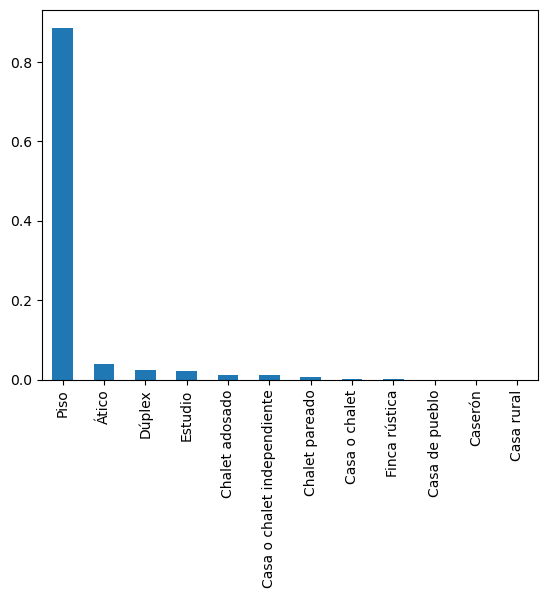

In [9]:
df["TYPE_PROPERTY"].value_counts(normalize=True).plot(kind="bar")

## Address and geolocation properties

In [10]:
# Remove records that do not contain madrid either in the address or the location
df = df[
    df["ADDRESS"].str.contains("madrid", case=False)
    | df["LOCATION"].str.contains("madrid", case=False)
]
df = df.reset_index(drop=True)
# Keep track of how many rows are removed in each step
n_removed.append(n - len(df))
print(f"Rows removed in Step 2: {n_removed[1]} - {n_removed[1] / n * 100:.2f}%")
n = len(df)

Rows removed in Step 2: 11 - 0.02%


In [11]:
# Load streets inventory from the Madrid City Council
df_streets = pd.read_excel("data/df_streets_inventory.xlsx")
# Load relationship of districts, neighborhoods and zip codes
df_districts = pd.read_excel("data/df_madrid_neighborhoods.xlsx")
df_districts["ZIP_CODES"] = df_districts["ZIP_CODES"].astype(str)

In [12]:
# Concatenate the district and neighborhood cols into a unique int column
df_streets["ID_BARRIO"] = (
    df_streets["DISTRITO"].fillna(0).astype(int).astype(str)
    + df_streets["BARRIO"].fillna(0).astype(int).astype(str)
).astype(int)
# Merge with district DataFrame to get district names
df_streets = df_streets.merge(
    df_districts[["ID", "DISTRICT_NO_ACCENT", "NEIGHBORHOOD_NO_ACCENT"]],
    left_on="ID_BARRIO",
    right_on="ID",
    how="left",
)
# Rename the merged column for district names
df_streets.rename(
    columns={
        "DISTRICT_NO_ACCENT": "DISTRITO_NOMBRE",
        "NEIGHBORHOOD_NO_ACCENT": "BARRIO_NOMBRE",
    },
    inplace=True,
)
# Optionally drop the additional 'ID' column if not needed
df_streets.drop(columns=["ID"], inplace=True)

In [13]:
# Get the base address from the ADDRESS column, removing the location
df["ADDRESS_BASE"] = df.apply(
    lambda row: row["ADDRESS"].replace(row["LOCATION"], "").rstrip(" ,"), axis=1
)
# If Urb. is the first word, remove it - Not a track class or either a street or location
df["ADDRESS_BASE"] = df["ADDRESS_BASE"].apply(lambda x: re.sub("^Urb.", "", x).strip())

In [14]:
# Get track class from the ADDRESS_BASE column (e.g. "Calle", "Avenida", etc.)
# It is expected that the track class is the first word in the address
df["TRACK_CLASS"] = df["ADDRESS_BASE"].apply(lambda x: x.split()[0])

In [15]:
# Extract track class in a standard format
df = extract_and_store_patterns(df, TRACK_CLASSES, "TRACK_CLASS", "TRACK_CLASS")

In [16]:
# Remove TRACK_CLASS from ADDRESS_BASE, if TRACK_CLASS is not empty
# Ignore case when replacing
# Replace only when ADDRESS_BASE contains a space, i.e. has more than one word
# We do not expect to find the track class in the address if it is a single word
df["ADDRESS_BASE"] = df.apply(
    lambda row: re.sub(
        re.escape(row["TRACK_CLASS"]), "", row["ADDRESS_BASE"], flags=re.IGNORECASE
    )
    if pd.notna(row["TRACK_CLASS"]) and " " in row["ADDRESS_BASE"]
    else row["ADDRESS_BASE"],
    axis=1,
)

In [17]:
# Remove spanish prepositions between TRACK_CLASS and TRACK_NAME
# Some prepositions such as "la, las, los" can be part of the track name
prepositions = ["del", "de", "al", "a"]
prepositions_regex = r"^((" + "|".join(prepositions) + r")\s+)"
df["ADDRESS_BASE"] = df["ADDRESS_BASE"].apply(
    lambda address: re.sub(
        prepositions_regex, "", address.strip(), flags=re.IGNORECASE
    ).strip()
)

In [18]:
# Correct common track names misspellings in Madrid - could be automated with ML
# If the track name contains a misspelling, replace it with the correct name
df["ADDRESS_BASE"] = df["ADDRESS_BASE"].apply(
    lambda address: correct_spelling(address, MISSPELLINGS_MADRID)
)

In [19]:
# Get unique district/neighborhood names with/without accents from the districts relationship
neighborhood_names = get_unique_names(df_districts, "NEIGHBORHOOD_NO_ACCENT")
district_names = get_unique_names(df_districts, "DISTRICT_NO_ACCENT")

# Extract district and neighborhood from the address, if available
ignore_prepositions = ["a", "en", "al", "de", "del", "la", "el", "los", "las"]
df = extract_and_store_patterns(
    df,
    neighborhood_names,
    "ADDRESS_BASE_NEIGHBORHOOD",
    "ADDRESS_BASE",
    ignore_prepositions=ignore_prepositions,
)
df = extract_and_store_patterns(
    df,
    district_names,
    "ADDRESS_BASE_DISTRICT",
    "ADDRESS_BASE",
    composed=True,
    ignore_prepositions=ignore_prepositions,
)

In [20]:
# Get unique track names with/without accents from the streets inventory
track_names = get_unique_names(df_streets, "VIA_NOMBRE")
# If any of the track names with/without accents is found in the address, it is extracted
df = extract_and_store_patterns(
    df,
    track_names,
    "TRACK_NAME",
    "ADDRESS_BASE",
    ignore_prepositions=ignore_prepositions,
)

In [21]:
# Remove TRACK_NAME:
# if TRACK_CLASS is empty and
# if ADDRESS_BASE_DISTRICT or ADDRESS_BASE_NEIGHBORHOOD are not empty and is equal to TRACK_NAME
# I.e, the address contains a district or neighborhood and not a track name
df["TRACK_NAME"] = df.apply(
    lambda row: np.nan
    if pd.isna(row["TRACK_CLASS"])
    and (
        pd.notna(row["ADDRESS_BASE_NEIGHBORHOOD"])
        or pd.notna(row["ADDRESS_BASE_DISTRICT"])
    )
    and (
        row["ADDRESS_BASE_NEIGHBORHOOD"] == row["TRACK_NAME"]
        or row["ADDRESS_BASE_DISTRICT"] == row["TRACK_NAME"]
    )
    else row["TRACK_NAME"],
    axis=1,
)

In [22]:
# Extract street numbers from the address
df["STREET_NUMBER"] = df["ADDRESS_BASE"].str.extract(r"(\d+)")
# Replace street numbers with np.nan where TRACK_NAME is null
df.loc[df["TRACK_NAME"].isna(), "STREET_NUMBER"] = np.nan

In [23]:
# Replace old neighborhood names with new ones
df["LOCATION"] = df["LOCATION"].apply(
    lambda x: correct_spelling(
        x,
        {
            "las tablas": "valverde",
            "palos de moguer": "palos de la frontera",
            "san andres": "villaverde alto - casco historico de villaverde",
            "villaverde alto": "villaverde alto - casco historico de villaverde",
            "valderribas": "valderrivas",
        },
    )
)

In [24]:
# Given the location of the listing, get the district and neighborhood
df = extract_and_store_patterns(
    df,
    neighborhood_names,
    "LOCATION_NEIGHBORHOOD",
    "LOCATION",
    ignore_prepositions=ignore_prepositions,
)

df = extract_and_store_patterns(
    df,
    district_names,
    "LOCATION_DISTRICT",
    "LOCATION",
    composed=True,
    ignore_prepositions=ignore_prepositions,
)

In [25]:
# Fill missing LOCATION_NEIGHBORHOOD with ADDRESS_BASE_NEIGHBORHOOD
df["LOCATION_NEIGHBORHOOD"] = df["LOCATION_NEIGHBORHOOD"].fillna(
    df["ADDRESS_BASE_NEIGHBORHOOD"]
)

In [26]:
# Get district (when is not available) when the neighborhood is available
df["LOCATION_DISTRICT"] = df.apply(
    lambda row: df_districts[
        df_districts["NEIGHBORHOOD_NO_ACCENT"] == row["LOCATION_NEIGHBORHOOD"]
    ]["DISTRICT_NO_ACCENT"].values[0]
    if pd.notna(row["LOCATION_NEIGHBORHOOD"]) and pd.isna(row["LOCATION_DISTRICT"])
    else row["LOCATION_DISTRICT"],
    axis=1,
)

In [27]:
# Fill missing LOCATION_DISTRICT with ADDRESS_BASE_DISTRICT
df["LOCATION_DISTRICT"] = df["LOCATION_DISTRICT"].fillna(df["ADDRESS_BASE_DISTRICT"])

In [28]:
# Fill TRACK_CLASS using the TRACK_NAME, DISTRICT and NEIGHBORHOOD (streets inventory)
df_merged = df.merge(
    df_streets[
        ["VIA_NOMBRE", "DISTRITO_NOMBRE", "BARRIO_NOMBRE", "VIA_CLASE"]
    ].drop_duplicates(),
    left_on=["TRACK_NAME", "LOCATION_DISTRICT", "LOCATION_NEIGHBORHOOD"],
    right_on=["VIA_NOMBRE", "DISTRITO_NOMBRE", "BARRIO_NOMBRE"],
    how="left",
)
# Keep the first record in case of duplicates (same track name, district and neighborhood)
# But different track class
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)
df["TRACK_CLASS"] = df["TRACK_CLASS"].fillna(df_merged["VIA_CLASE"])

# Fill TRACK_CLASS using the TRACK_NAME, DISTRICT (streets inventory)
df_merged = df.merge(
    df_streets[["VIA_NOMBRE", "DISTRITO_NOMBRE", "VIA_CLASE"]].drop_duplicates(),
    left_on=["TRACK_NAME", "LOCATION_DISTRICT"],
    right_on=["VIA_NOMBRE", "DISTRITO_NOMBRE"],
    how="left",
)
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)
df["TRACK_CLASS"] = df["TRACK_CLASS"].fillna(df_merged["VIA_CLASE"])

# Fill TRACK_CLASS using the TRACK_NAME only
df_merged = df.merge(
    df_streets[["VIA_NOMBRE", "VIA_CLASE"]].drop_duplicates(),
    left_on=["TRACK_NAME"],
    right_on=["VIA_NOMBRE"],
    how="left",
)
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)
df["TRACK_CLASS"] = df["TRACK_CLASS"].fillna(df_merged["VIA_CLASE"])

In [29]:
# Cast street number to float
df_streets.NUMERO = df_streets.NUMERO.astype(float)
df.STREET_NUMBER = df.STREET_NUMBER.astype(float)

# Get DISTRICT AND NEIGHBORHOOD from the streets inventory, when the full address is available
df_merged = df.merge(
    df_streets[
        [
            "VIA_CLASE",
            "VIA_NOMBRE",
            "NUMERO",
            "BARRIO_NOMBRE",
            "DISTRITO_NOMBRE",
            "COD_NDP",
            "COD_VIA",
            "COD_POSTAL",
        ]
    ].drop_duplicates(),
    left_on=["TRACK_CLASS", "TRACK_NAME", "STREET_NUMBER"],
    right_on=["VIA_CLASE", "VIA_NOMBRE", "NUMERO"],
    how="left",
)
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)

# Fill missing LOCATION_NEIGHBORHOOD and LOCATION_DISTRICT
df = fill_na_df(
    df,
    df_merged,
    ["LOCATION_NEIGHBORHOOD", "LOCATION_DISTRICT"],
    ["BARRIO_NOMBRE", "DISTRITO_NOMBRE"],
)

# Get COD_NDP, COD_VIA, COD_POSTAL
df[["COD_NDP", "COD_VIA", "COD_POSTAL"]] = df_merged[
    ["COD_NDP", "COD_VIA", "COD_POSTAL"]
]

In [30]:
# Get DISTRICT AND NEIGHBORHOOD from the TRACK_CLASS, TRACK_NAME and LOCATION
df_merged = df.merge(
    df_streets[
        [
            "VIA_CLASE",
            "VIA_NOMBRE",
            "BARRIO_NOMBRE",
            "DISTRITO_NOMBRE",
            "COD_NDP",
            "COD_VIA",
            "COD_POSTAL",
        ]
    ].drop_duplicates(),
    left_on=["TRACK_CLASS", "TRACK_NAME", "LOCATION_NEIGHBORHOOD", "LOCATION_DISTRICT"],
    right_on=["VIA_CLASE", "VIA_NOMBRE", "BARRIO_NOMBRE", "DISTRITO_NOMBRE"],
    how="left",
)
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)

# Fill missing 'LOCATION_NEIGHBORHOOD' and 'LOCATION_DISTRICT'
df = fill_na_df(
    df,
    df_merged,
    ["LOCATION_NEIGHBORHOOD", "LOCATION_DISTRICT"],
    ["BARRIO_NOMBRE", "DISTRITO_NOMBRE"],
)

# Fill missing COD_NDP, COD_VIA, COD_POSTAL
df = fill_na_df(
    df,
    df_merged,
    ["COD_NDP", "COD_VIA", "COD_POSTAL"],
    ["COD_NDP_y", "COD_VIA_y", "COD_POSTAL_y"],
)

In [31]:
# Get DISTRICT AND NEIGHBORHOOD from the TRACK_CLASS, TRACK_NAME and DISTRICT
df_merged = df.merge(
    df_streets[
        [
            "VIA_CLASE",
            "VIA_NOMBRE",
            "BARRIO_NOMBRE",
            "DISTRITO_NOMBRE",
            "COD_NDP",
            "COD_VIA",
            "COD_POSTAL",
        ]
    ].drop_duplicates(),
    left_on=["TRACK_CLASS", "TRACK_NAME", "LOCATION_DISTRICT"],
    right_on=["VIA_CLASE", "VIA_NOMBRE", "DISTRITO_NOMBRE"],
    how="left",
)
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)

# Fill missing 'LOCATION_NEIGHBORHOOD' and 'LOCATION_DISTRICT'
df = fill_na_df(
    df,
    df_merged,
    ["LOCATION_NEIGHBORHOOD", "LOCATION_DISTRICT"],
    ["BARRIO_NOMBRE", "DISTRITO_NOMBRE"],
)

# Fill missing COD_NDP, COD_VIA, COD_POSTAL
df = fill_na_df(
    df,
    df_merged,
    ["COD_NDP", "COD_VIA", "COD_POSTAL"],
    ["COD_NDP_y", "COD_VIA_y", "COD_POSTAL_y"],
)

In [32]:
# Get DISTRICT AND NEIGHBORHOOD from the TRACK_CLASS and TRACK_NAME
df_merged = df.merge(
    df_streets[
        [
            "VIA_CLASE",
            "VIA_NOMBRE",
            "BARRIO_NOMBRE",
            "DISTRITO_NOMBRE",
            "COD_NDP",
            "COD_VIA",
            "COD_POSTAL",
        ]
    ].drop_duplicates(),
    left_on=["TRACK_CLASS", "TRACK_NAME"],
    right_on=["VIA_CLASE", "VIA_NOMBRE"],
    how="left",
)
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)

# Fill missing 'LOCATION_NEIGHBORHOOD' and 'LOCATION_DISTRICT'
df = fill_na_df(
    df,
    df_merged,
    ["LOCATION_NEIGHBORHOOD", "LOCATION_DISTRICT"],
    ["BARRIO_NOMBRE", "DISTRITO_NOMBRE"],
)

# Fill missing COD_NDP, COD_VIA, COD_POSTAL
df = fill_na_df(
    df,
    df_merged,
    ["COD_NDP", "COD_VIA", "COD_POSTAL"],
    ["COD_NDP_y", "COD_VIA_y", "COD_POSTAL_y"],
)

In [33]:
# Get COD_NDP, COD_VIA, COD_POSTAL from the TRACK_NAME, NEIGHBORHOOD and DISTRICT
df_merged = df.merge(
    df_streets[
        [
            "VIA_CLASE",
            "VIA_NOMBRE",
            "BARRIO_NOMBRE",
            "DISTRITO_NOMBRE",
            "COD_NDP",
            "COD_VIA",
            "COD_POSTAL",
        ]
    ].drop_duplicates(),
    left_on=["TRACK_NAME", "LOCATION_NEIGHBORHOOD", "LOCATION_DISTRICT"],
    right_on=["VIA_NOMBRE", "BARRIO_NOMBRE", "DISTRITO_NOMBRE"],
    how="left",
)
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)

# Fill missing COD_NDP, COD_VIA, COD_POSTAL
df = fill_na_df(
    df,
    df_merged,
    ["COD_NDP", "COD_VIA", "COD_POSTAL"],
    ["COD_NDP_y", "COD_VIA_y", "COD_POSTAL_y"],
)

In [34]:
# Get COD_POSTAL from NEIGHBORHOOD and DISTRICT
df_merged = df.merge(
    df_districts[
        [
            "DISTRICT_NO_ACCENT",
            "NEIGHBORHOOD_NO_ACCENT",
            "ZIP_CODES",
        ]
    ].drop_duplicates(),
    left_on=["LOCATION_DISTRICT", "LOCATION_NEIGHBORHOOD"],
    right_on=["DISTRICT_NO_ACCENT", "NEIGHBORHOOD_NO_ACCENT"],
    how="left",
)
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.reset_index(drop=True, inplace=True)

# Generate random ZIP code for each row in df_merged
random_zip_code = df_merged["ZIP_CODES"].apply(
    lambda x: float(random.choice(x.strip().split(","))) if pd.notna(x) else np.nan
)
# Define the conditions under which COD_POSTAL will be replaced
condition = (
    pd.isna(df["TRACK_NAME"])
    & pd.notna(df["LOCATION_DISTRICT"])
    & pd.notna(df["LOCATION_NEIGHBORHOOD"])
)
# Replace COD_POSTAL under the defined conditions
df.loc[condition, "COD_POSTAL"] = random_zip_code[df.index[condition]]

In [35]:
# Remove cases with missing COD_POSTAL and TRACK_NAME
df = df[~((df["COD_POSTAL"].isna()) & (df["TRACK_NAME"].isna()))]
# Remove cases with TRACK_NAME, but missing NEIGHBORHOOD and DISTRICT
df = df[
    ~(
        (df["TRACK_NAME"].notna())
        & (df["LOCATION_NEIGHBORHOOD"].isna())
        & (df["LOCATION_DISTRICT"].isna())
    )
]
df.reset_index(drop=True, inplace=True)
# Keep track of how many rows are removed in each step
n_removed.append(n - len(df))
print(f"Rows removed in Step 3: {n_removed[2]} - {n_removed[2] / n * 100:.2f}%")
n = len(df)


Rows removed in Step 3: 52 - 0.10%


In [48]:
df2 = df.copy()

In [101]:
df = df2.copy()

In [102]:
# Correct track names that were capture incorrectly, only for records with missing COD_POSTAL
index = df[df["COD_POSTAL"].isna()].index
# Due to ignoring prepositions initially
# Due to streets that include a track class in its name (Calle del Camino de Santiago)
df.loc[index] = extract_and_store_patterns(
    df.loc[index],
    track_names,
    "TRACK_NAME",
    "ADDRESS",
    # ignore_prepositions=ignore_prepositions,
)

# Get COD_NDP, COD_VIA, COD_POSTAL from the TRACK_NAME, NEIGHBORHOOD and DISTRICT
df.loc[index, "original_index"] = df.loc[index].index
# Splitting the DataFrame based on whether STREET_NUMBER is missing
df_with_street_number = df.loc[
    index.intersection(df[df["STREET_NUMBER"].notna()].index)
]
df_without_street_number = df.loc[
    index.intersection(df[df["STREET_NUMBER"].isna()].index)
]

# First merge (including STREET_NUMBER)
df_merged_with = df_with_street_number.merge(
    df_streets[
        [
            "VIA_CLASE",
            "VIA_NOMBRE",
            "NUMERO",
            "BARRIO_NOMBRE",
            "DISTRITO_NOMBRE",
            "COD_NDP",
            "COD_VIA",
            "COD_POSTAL",
        ]
    ].drop_duplicates(),
    left_on=[
        "TRACK_NAME",
        "LOCATION_NEIGHBORHOOD",
        "LOCATION_DISTRICT",
        "STREET_NUMBER",
    ],
    right_on=["VIA_NOMBRE", "BARRIO_NOMBRE", "DISTRITO_NOMBRE", "NUMERO"],
    how="left",
)

# Second merge (excluding STREET_NUMBER)
df_merged_without = df_without_street_number.merge(
    df_streets[
        [
            "VIA_CLASE",
            "VIA_NOMBRE",
            "BARRIO_NOMBRE",
            "DISTRITO_NOMBRE",
            "COD_NDP",
            "COD_VIA",
            "COD_POSTAL",
        ]
    ].drop_duplicates(),
    left_on=["TRACK_NAME", "LOCATION_NEIGHBORHOOD", "LOCATION_DISTRICT"],
    right_on=["VIA_NOMBRE", "BARRIO_NOMBRE", "DISTRITO_NOMBRE"],
    how="left",
)

# Concatenating the results
df_merged = pd.concat([df_merged_with, df_merged_without])
df_merged = df_merged.sort_values(by="original_index")
df_merged.drop("original_index", axis=1, inplace=True)

# # Post-merge processing
df_merged = df_merged.drop_duplicates(subset="ID_LISTING", keep="first")
df_merged.set_index(index, inplace=True)

# Fill missing COD_NDP, COD_VIA, COD_POSTAL
df.loc[index] = fill_na_df(
    df.loc[index],
    df_merged,
    ["COD_NDP", "COD_VIA", "COD_POSTAL"],
    ["COD_NDP_y", "COD_VIA_y", "COD_POSTAL_y"],
)


In [104]:
# Remove remaining cases with missing COD_POSTAL
df = df[df["COD_POSTAL"].notna()]
df.reset_index(drop=True, inplace=True)
# Keep track of how many rows are removed in each step
n_removed.append(n - len(df))
print(f"Rows removed in Step 4: {n_removed[3]} - {n_removed[3] / n * 100:.2f}%")
n = len(df)


Rows removed in Step 3: 30 - 0.06%
